In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from helpers import *


# Cleaning Up the Best Track Data

## Reading Data

In [34]:
PATH_BT = '/home/orca/data/best_track/IBTrACS/' #Set Data Path Here!!
Cleaned_Data_Path = '/home/disk/orca/adaley17/MLGEO2024_TC_Tracks_Intensity/data/clean/' #Set path to save PNG Files
track_file = 'ibtracs.NA.list.v04r00.csv' #Set Track File Here!!

df = pd.read_csv(PATH_BT + track_file) #Read in the data

df.index = pd.to_datetime(df['ISO_TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce') #Set the index to the time of the storm


<ipython-input-34-051f25a47c2a>:5: DtypeWarning: Columns (1,2,3,8,9,14,19,20,23,24,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PATH_BT + track_file) #Read in the data


## Removing Data Prior to 1982

Isolate data from 1982 onwards and all the Named Storms since there is uncertainty surrounding records before 1982 (Prior to the Satellite Era)

In [35]:
df_1980_onwards = df[df.index.year >= 1982] #identify the storms that occurred after 1982

named_storms = df_1980_onwards[df_1980_onwards['NAME'] != 'NOT_NAMED'] #identify the named storms

named_storms.loc[:, 'BASIN'] = named_storms['BASIN'].fillna('NA') #Replace NaN values with NA (North Atlantic)

named_storms.loc[:, 'SUBBASIN'] = named_storms['SUBBASIN'].fillna('MM') #Replace NaN values with MM (Missing)
named_storms.head()



,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
ISO_TIME,,,,,,,,,,,,,,,,,,,,,
1982-06-02 12:00:00,1982154N22273,1982,33,NA,GM,ALBERTO,1982-06-02 12:00:00,TS,21.7,-87.1,...,,,,,,,,,7,47
1982-06-02 15:00:00,1982154N22273,1982,33,NA,GM,ALBERTO,1982-06-02 15:00:00,TS,21.9551,-86.8077,...,,,,,,,,,8,48
1982-06-02 18:00:00,1982154N22273,1982,33,NA,GM,ALBERTO,1982-06-02 18:00:00,TS,22.2,-86.5,...,,,,,,,,,8,52
1982-06-02 21:00:00,1982154N22273,1982,33,NA,GM,ALBERTO,1982-06-02 21:00:00,TS,22.4224,-86.165,...,,,,,,,,,8,58
1982-06-03 00:00:00,1982154N22273,1982,33,NA,GM,ALBERTO,1982-06-03 00:00:00,TS,22.6,-85.8,...,,,,,,,,,8,68


## Identify Columns of Interest

Currently the data has 163 columns but we are only interesed in the following:
1.  ISO_TIME
2.  USA_ATCF_ID
3.  NAME
4.  DIST2LAND
5.  LANDFALL
6.  STORM_SPEED
7.  STORM_DIR
8.  USA_RMW
9.  USA_LAT
10.  USA_LON
11.  USA_WIND
12.  USA_PRES

In [36]:
# for column in df.columns:
#     print(column) #print the columns in the dataframe

# num_columns = len(df.columns)
# print(f"Number of columns: {num_columns}")
columns_of_interest = [
    'USA_ATCF_ID', 'NAME', 'DIST2LAND', 'LANDFALL', 'STORM_SPEED', 
    'STORM_DIR', 'USA_LAT', 'USA_LON', 'USA_WIND', 'USA_PRES', 'USA_RMW'
]

df_selected = named_storms[columns_of_interest]
df_selected.head()

,USA_ATCF_ID,NAME,DIST2LAND,LANDFALL,STORM_SPEED,STORM_DIR,USA_LAT,USA_LON,USA_WIND,USA_PRES,USA_RMW
ISO_TIME,,,,,,,,,,,
1982-06-02 12:00:00,AL011982,ALBERTO,22,22,7,47,21.7,-87.1,20,1005,
1982-06-02 15:00:00,AL011982,ALBERTO,59,59,8,48,21.9551,-86.8077,22,1004,
1982-06-02 18:00:00,AL011982,ALBERTO,93,93,8,52,22.2,-86.5,25,1004,
1982-06-02 21:00:00,AL011982,ALBERTO,130,113,8,58,22.4224,-86.165,27,1003,
1982-06-03 00:00:00,AL011982,ALBERTO,113,98,8,68,22.6,-85.8,30,1003,


## Final Clean Up

- Convert Wind Speed from kts to m/s
- Convert distances from Nautical Miles to m
- replace empty entries in USA_RMW with nans

In [39]:
df_selected.loc[:, 'DIST2LAND'] = pd.to_numeric(df_selected['DIST2LAND'], errors='coerce') * 1 #Convert distance to land from nautical miles to m
df_selected.loc[:, 'LANDFALL'] = pd.to_numeric(df_selected['LANDFALL'], errors='coerce') * 1852 #Convert distance to land from nautical miles to m
df_selected.loc[:, 'STORM_SPEED'] = pd.to_numeric(df_selected['STORM_SPEED'], errors='coerce') * 0.514444 #Convert storm speed from knots to m/s
df_selected.loc[:, 'USA_WSPD'] = pd.to_numeric(df_selected['USA_WIND'], errors='coerce') * 0.514444 #Convert wind speed from knots to m/s
df_selected.loc[:, 'USA_PRES'] = pd.to_numeric(df_selected['USA_PRES'], errors='coerce') * 1
df_selected.loc[:, 'USA_RMW'] = pd.to_numeric(df_selected['USA_RMW'].replace(' ', np.nan), errors='coerce') #The units here are unclear

df_selected.to_csv(Cleaned_Data_Path + 'cleaned_best_track_data.csv', index=True)

## Visualizing Data to Identify Possible Outliers

<AxesSubplot:xlabel='ISO_TIME'>

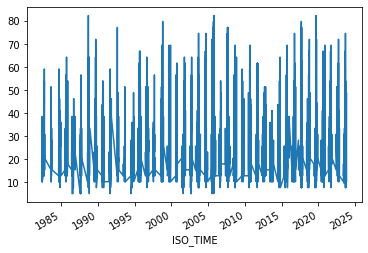

In [24]:
df_selected['USA_WSPD'].plot()

<AxesSubplot:xlabel='ISO_TIME'>

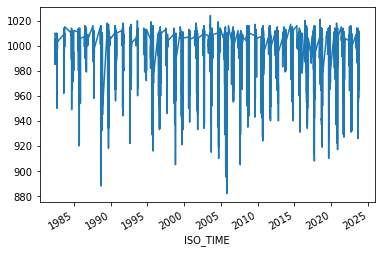

In [25]:
df_selected['USA_PRES'].plot()

<AxesSubplot:xlabel='ISO_TIME'>

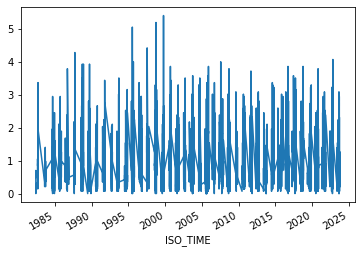

In [26]:
df_selected['STORM_SPEED'].plot()

<AxesSubplot:xlabel='ISO_TIME'>

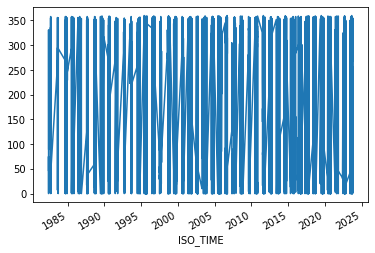

In [27]:
df_selected['STORM_DIR'].plot()

<AxesSubplot:xlabel='ISO_TIME'>

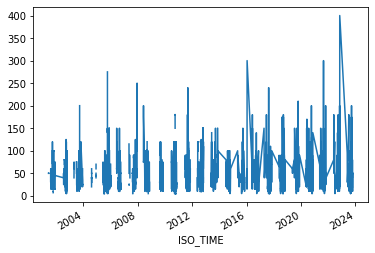

In [31]:
df_selected['USA_RMW'].plot()

In [36]:
df_selected['USA_RMW'] = pd.to_numeric(df_selected['USA_RMW'], errors='coerce')
max_usa_rmw = df_selected['USA_RMW'].min()
print(f"Maximum USA_RMW: {max_usa_rmw}")

Maximum USA_RMW: 5.0


<ipython-input-36-275bb2609e76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['USA_RMW'] = pd.to_numeric(df_selected['USA_RMW'], errors='coerce')


In [31]:
df_selected['USA_RMW'].describe()

count     19384
unique      104
top          30
freq       2342
Name: USA_RMW, dtype: object

In [7]:
unique_names_count = named_storms['SID'].nunique()
print(f"Number of unique names: {unique_names_count}")


Number of unique names: 559


In [23]:
#cartopy Info
crs = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale='high', levels=[1,], edgecolor='k')
lakes = cfeature.GSHHSFeature(scale='high', levels=[2,], edgecolor='face',facecolor='grey')
borders = cfeature.BORDERS

#Track Domain
min_lat_track = 0
max_lat_track = 50
min_lon_track = -100
max_lon_track = -10

#Set Plot Area
plot_area_track = [max_lon_track + 360.0, min_lon_track + 360.0, min_lat_track,max_lat_track]

## Track Locations

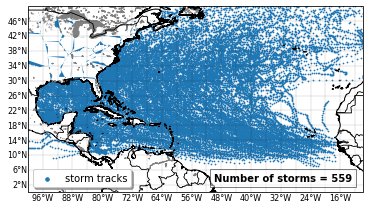

In [24]:
gridsize = (1, 1)
fig = plt.figure(figsize=(6,6))

#Track
ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1, projection=crs)

ax1.scatter(named_storms.LON.values, named_storms.LAT.values, marker='o', s=0.5, zorder=-100, label='storm tracks')
Cartopy_Features(ax1, 8, plot_area_track, 4, 4, 'k')

ax1.text(-50, 3, 'Number of storms = ' + str(unique_names_count), fontsize=10, color='black', 
         fontweight='bold', bbox=dict(facecolor='white', alpha=0.5))

ax1.legend(loc='lower left', fontsize=10, markerscale=5,  frameon=True, fancybox=True, shadow=True)

plt.savefig(PNG + 'tracks.png', dpi=300, bbox_inches='tight',
                facecolor='w', transparent=False)

plt.show()


## Dostribution of Tracks

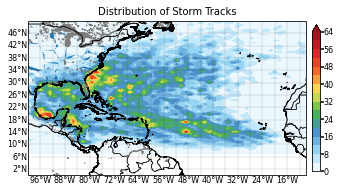

In [55]:
shrink=0.45

aspect=18
width=0.5
length=4
labelsize=8
levels=np.arange(0, 68, 4)

gridsize = (1, 1)
fig = plt.figure(figsize=(6,6))

ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1, projection=crs)

lon_bins = np.linspace(named_storms.LON.min(), named_storms.LON.max(), 100)
lat_bins = np.linspace(named_storms.LAT.min(), named_storms.LAT.max(), 100)

density, _, _ = np.histogram2d(named_storms.LON, named_storms.LAT, bins=[lon_bins, lat_bins])

lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins[0:-1], lat_bins[0:-1])

track_density = ax1.contourf(lon_bins_2d, lat_bins_2d, density.T, cmap=cmaps.WhiteBlueGreenYellowRed,
                             levels=levels, extend='max')

Cartopy_Features(ax1, 8, plot_area_track, 4, 4, 'k')

hcb = fig.colorbar(track_density, shrink=shrink, aspect=aspect, ax=ax1, pad=0.02)
hcb.ax.tick_params(color='k', length=3, width=1.5, labelsize=labelsize, pad=0.002)

ax1.set_title('Distribution of Storm Tracks', fontsize=10, color='black')

plt.savefig(PNG + 'distribution_of_tracks.png', dpi=300, bbox_inches='tight',
                facecolor='w', transparent=False)

## Number of Storms per month

<ipython-input-68-0164584214e9>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ylabels, fontsize=fontsize)
<ipython-input-68-0164584214e9>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(storms_by_month.index, fontsize=fontsize, rotation=rotation, ha='right')


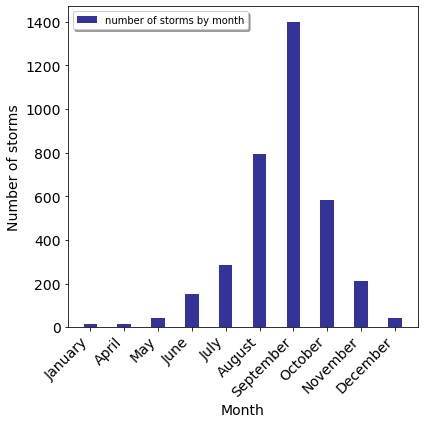

In [68]:
fontsize=14
rotation=45
alpha=0.8
ylabels=np.arange(0, 1600, 200)
# Group storms by month
storms_by_month = named_storms.groupby(named_storms.index.month).size()

# Rename the index to month names for better readability
storms_by_month.index = storms_by_month.index.map({1: 'January', 2: 'February', 3: 'March', 4: 
                                                   'April', 5: 'May', 6: 'June', 7: 'July', 8: 
                                                   'August', 9: 'September', 10: 'October', 11: 
                                                   'November', 12: 'December'})

gridsize = (1, 1)
fig = plt.figure(figsize=(6,6))

ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1)

ax1.bar(storms_by_month.index, storms_by_month.values, color='navy', alpha=alpha, width=0.4, 
        label='number of storms by month')

ax1.set_xlabel('Month', fontsize=fontsize)
ax1.set_ylabel('Number of storms', fontsize=fontsize)
ax1.set_yticklabels(ylabels, fontsize=fontsize)
ax1.set_xticklabels(storms_by_month.index, fontsize=fontsize, rotation=rotation, ha='right')

ax1.legend(loc='upper left', fontsize=10, markerscale=5,  frameon=True, fancybox=True, shadow=True)

plt.savefig(PNG + 'storms_by_month.png', dpi=300, bbox_inches='tight',
                facecolor='w', transparent=False)

plt.tight_layout()
plt.show()


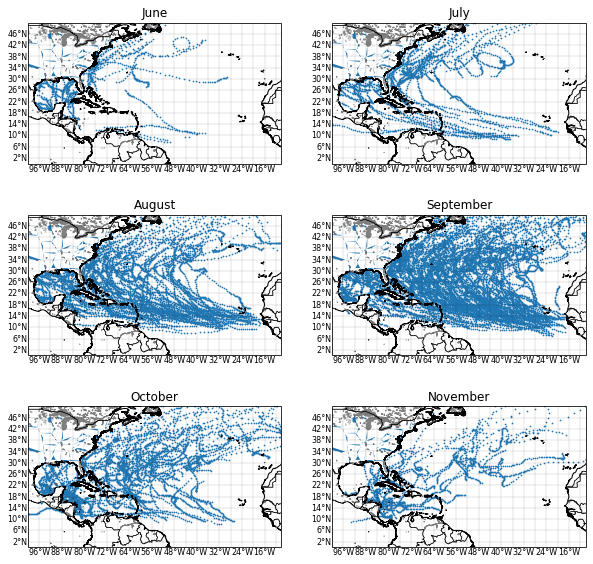

In [67]:
storms_june = named_storms[named_storms.index.month == 6]
storms_july = named_storms[named_storms.index.month == 7]
storms_august = named_storms[named_storms.index.month == 8]
storms_september = named_storms[named_storms.index.month == 9]
storms_october = named_storms[named_storms.index.month == 10]
storms_november = named_storms[named_storms.index.month == 11]

#Cartopy dependencies
crs = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale='high', levels=[1,], edgecolor='k')
lakes = cfeature.GSHHSFeature(scale='high', levels=[2,], edgecolor='face',facecolor='grey')
borders = cfeature.BORDERS

#Track Domain
min_lat_track = 0
max_lat_track = 50
min_lon_track = -100
max_lon_track = -10
plot_area_track = [max_lon_track + 360.0, min_lon_track + 360.0, min_lat_track,max_lat_track]

fontsize=12

gridsize = (3, 2)
fig = plt.figure(figsize=(10,10))

#June Tracks
ax1 = plt.subplot2grid(gridsize, (0,0), colspan=1, rowspan=1, projection=crs)

ax1.scatter(storms_june.LON.values, storms_june.LAT.values, marker='o', s=0.5, zorder=-100)
Cartopy_Features(ax1, 8, plot_area_track, 4, 4, 'k')

ax1.set_title('June', fontsize=fontsize)

#July Tracks
ax2 = plt.subplot2grid(gridsize, (0,1), colspan=1, rowspan=1, projection=crs)

ax2.scatter(storms_july.LON.values, storms_july.LAT.values, marker='o', s=0.5, zorder=-100)
Cartopy_Features(ax2, 8, plot_area_track, 4, 4, 'k')

ax2.set_title('July', fontsize=fontsize)

#August Tracks
ax3 = plt.subplot2grid(gridsize, (1,0), colspan=1, rowspan=1, projection=crs)

ax3.scatter(storms_august.LON.values, storms_august.LAT.values, marker='o', s=0.5, zorder=-100)
Cartopy_Features(ax3, 8, plot_area_track, 4, 4, 'k')

ax3.set_title('August', fontsize=fontsize)

#September Tracks
ax4 = plt.subplot2grid(gridsize, (1,1), colspan=1, rowspan=1, projection=crs)

ax4.scatter(storms_september.LON.values, storms_september.LAT.values, marker='o', s=0.5, zorder=-100)
Cartopy_Features(ax4, 8, plot_area_track, 4, 4, 'k')

ax4.set_title('September', fontsize=fontsize)

#October Tracks
ax5 = plt.subplot2grid(gridsize, (2,0), colspan=1, rowspan=1, projection=crs)
ax5.scatter(storms_october.LON.values, storms_october.LAT.values, marker='o', s=0.5, zorder=-100)

Cartopy_Features(ax5, 8, plot_area_track, 4, 4, 'k')
ax5.set_title('October', fontsize=fontsize)

#November Tracks
ax6 = plt.subplot2grid(gridsize, (2,1), colspan=1, rowspan=1, projection=crs)
ax6.scatter(storms_november.LON.values, storms_november.LAT.values, marker='o', s=0.5, zorder=-100)

Cartopy_Features(ax6, 8, plot_area_track, 4, 4, 'k')
ax6.set_title('November', fontsize=fontsize)

# fig.tight_layout(pad=0.025, w_pad=0.025, h_pad=0.0025)
plt.savefig(PNG + 'seasonal_tracks.png', dpi=300, bbox_inches='tight',
                facecolor='w', transparent=False)

plt.show()